C:\Users\nessi\AppData\Local\Temp\ipykernel_23368\3981452030.py:6: DtypeWarning: Columns (1,2,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'C:\Users\nessi\CLIP_Fine_Tuning\CLIP_Fine_Tuning\furniture-search-engine\data\processed\cleaned_furniture.csv')


### Missing Values per Column ###
style          848
color          761
material       771
object_type    755
dtype: int64
------------------------------


C:\Users\nessi\AppData\Local\Temp\ipykernel_23368\3981452030.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_n.values, y=top_n.index, palette='viridis')
C:\Users\nessi\AppData\Local\Temp\ipykernel_23368\3981452030.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_n.values, y=top_n.index, palette='viridis')
C:\Users\nessi\AppData\Local\Temp\ipykernel_23368\3981452030.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_n.values, y=top_n.index, palette='viridis')
C:\Users\nessi\AppData\Local\Temp\ipykernel_23368\39814

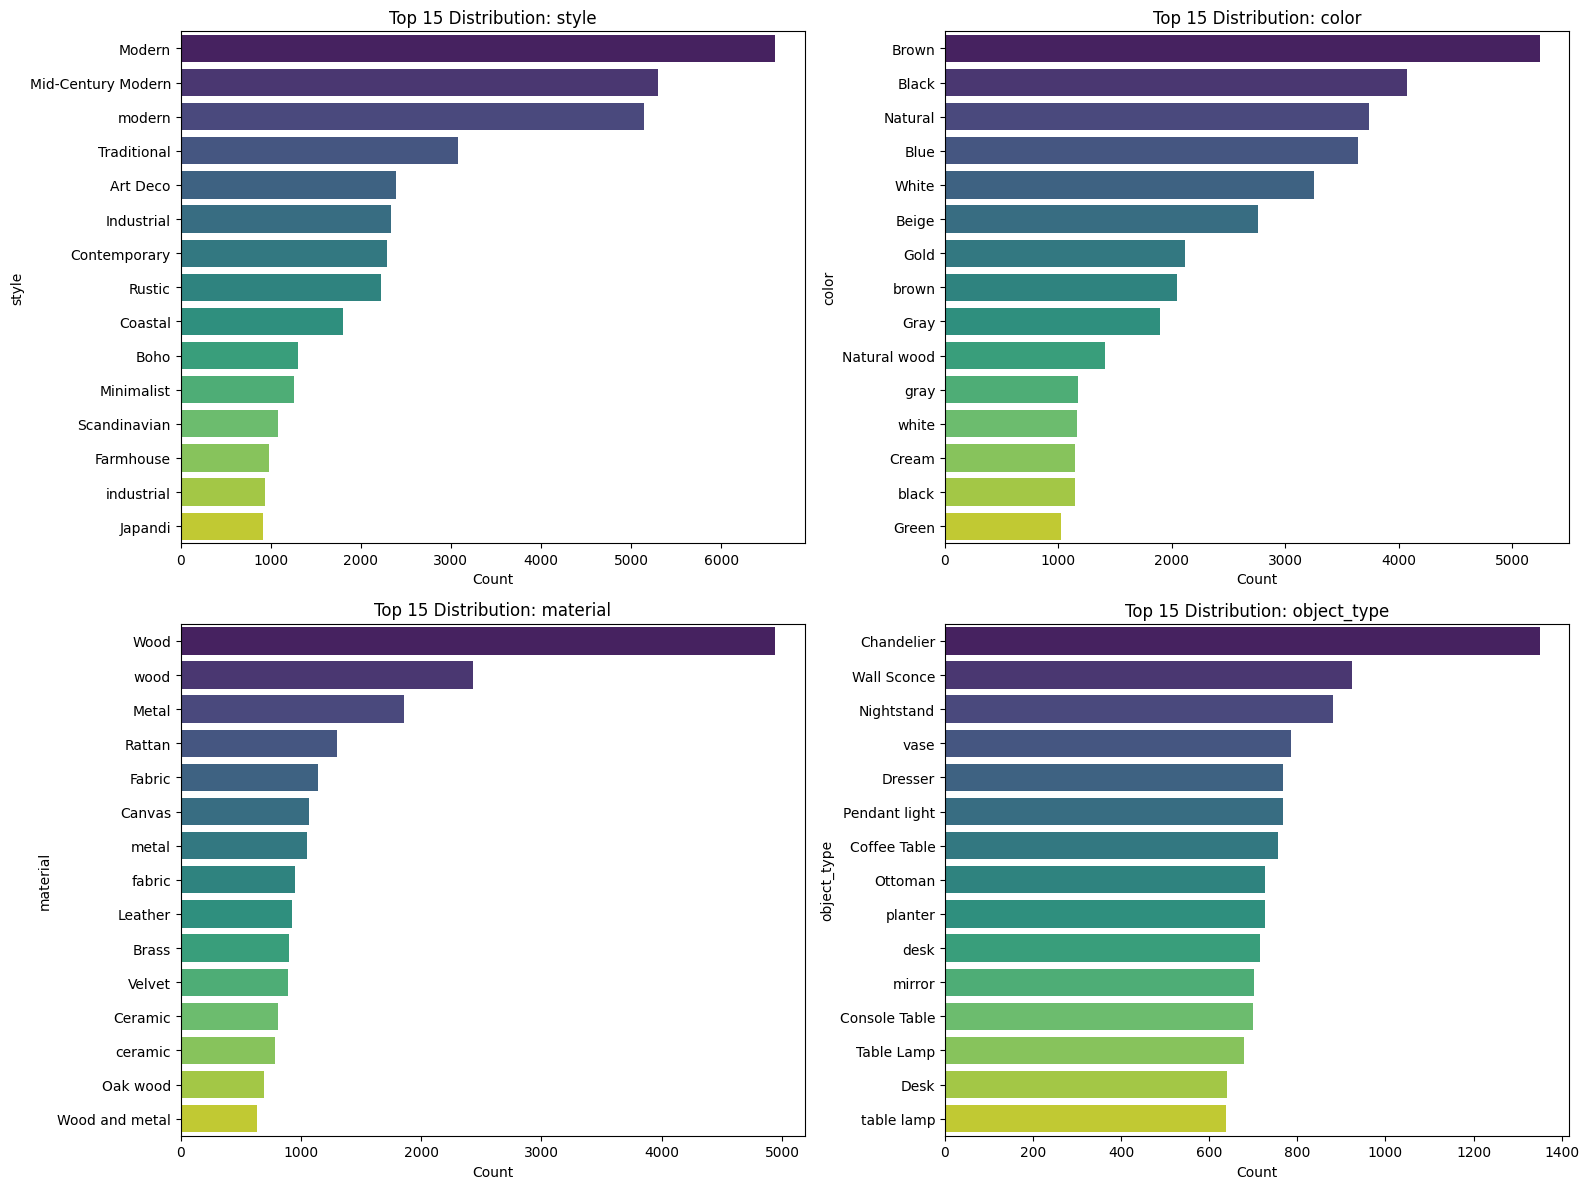

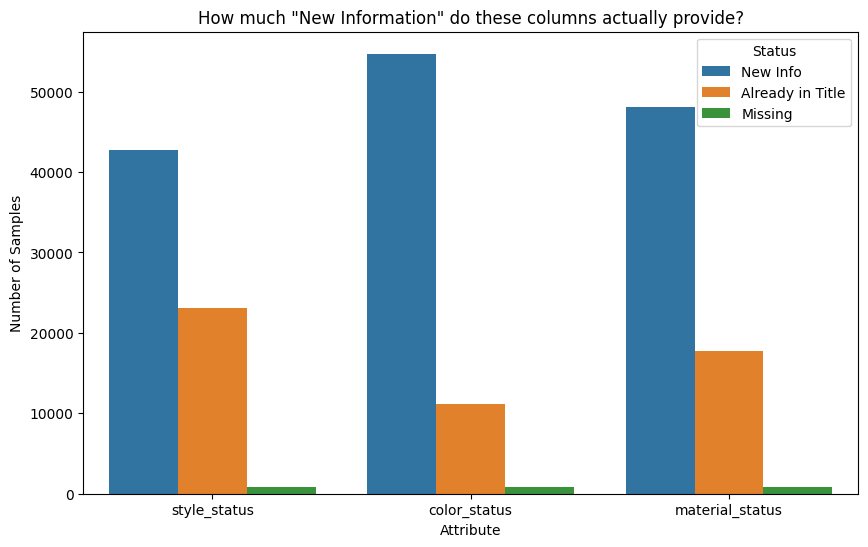

### Data Insights Summary ###
- style: 6245 unique classes. Most common: 'Modern' (9.9% of data)
- color: 4242 unique classes. Most common: 'Brown' (7.9% of data)
- material: 12553 unique classes. Most common: 'Wood' (7.4% of data)
- object_type: 5869 unique classes. Most common: 'Chandelier' (2.0% of data)


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load data
df = pd.read_csv(r'C:\Users\nessi\CLIP_Fine_Tuning\CLIP_Fine_Tuning\furniture-search-engine\data\processed\cleaned_furniture.csv')

# --- PRE-CHECK: Missing Values ---
print("### Missing Values per Column ###")
print(df[['style', 'color', 'material', 'object_type']].isnull().sum())
print("-" * 30)

# 2. Visualize Class Distributions
cols_to_analyze = ['style', 'color', 'material', 'object_type']

plt.figure(figsize=(16, 12))
for i, col in enumerate(cols_to_analyze, 1):
    plt.subplot(2, 2, i)
    # Take top 15 for readability if you have many classes
    top_n = df[col].value_counts().nlargest(15)
    sns.barplot(x=top_n.values, y=top_n.index, palette='viridis')
    plt.title(f'Top 15 Distribution: {col}')
    plt.xlabel('Count')

plt.tight_layout()
plt.show()

# 3. Analyze Redundancy (Insights for your prompt logic)
def check_redundancy(row, attr_col):
    title = str(row['cleaned_title']).lower()
    attr = str(row[attr_col]).lower()
    if attr == 'nan' or attr == 'none':
        return 'Missing'
    return 'Already in Title' if attr in title else 'New Info'

# Apply redundancy check
for attr in ['style', 'color', 'material']:
    df[f'{attr}_status'] = df.apply(lambda r: check_redundancy(r, attr), axis=1)

# 4. Plot Redundancy Insights
redundancy_cols = ['style_status', 'color_status', 'material_status']
melted_df = df[redundancy_cols].melt(var_name='Attribute', value_name='Status')

plt.figure(figsize=(10, 6))
sns.countplot(data=melted_df, x='Attribute', hue='Status')
plt.title('How much "New Information" do these columns actually provide?')
plt.ylabel('Number of Samples')
plt.show()

# 5. Summary Statistics
print("### Data Insights Summary ###")
for col in cols_to_analyze:
    unique_counts = df[col].nunique()
    top_val = df[col].mode()[0]
    top_pct = (df[col] == top_val).sum() / len(df) * 100
    print(f"- {col}: {unique_counts} unique classes. Most common: '{top_val}' ({top_pct:.1f}% of data)")

Loading CSV and building title map...


C:\Users\nessi\AppData\Local\Temp\ipykernel_23368\4201552807.py:18: DtypeWarning: Columns (1,2,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(CSV_PATH)


Found 44 groups. Displaying top 10:


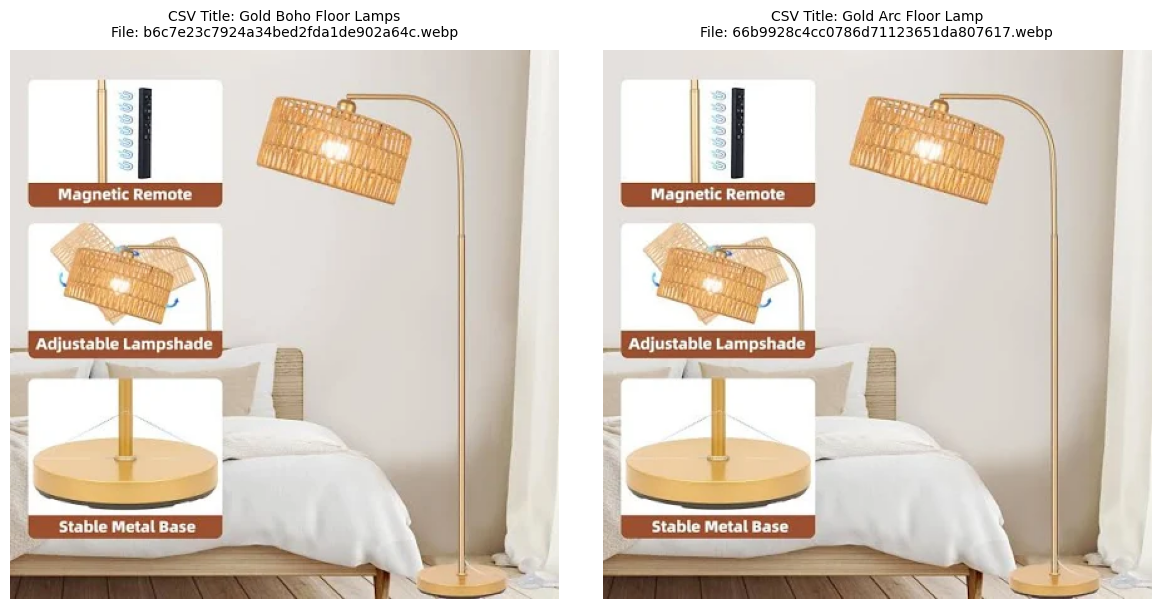

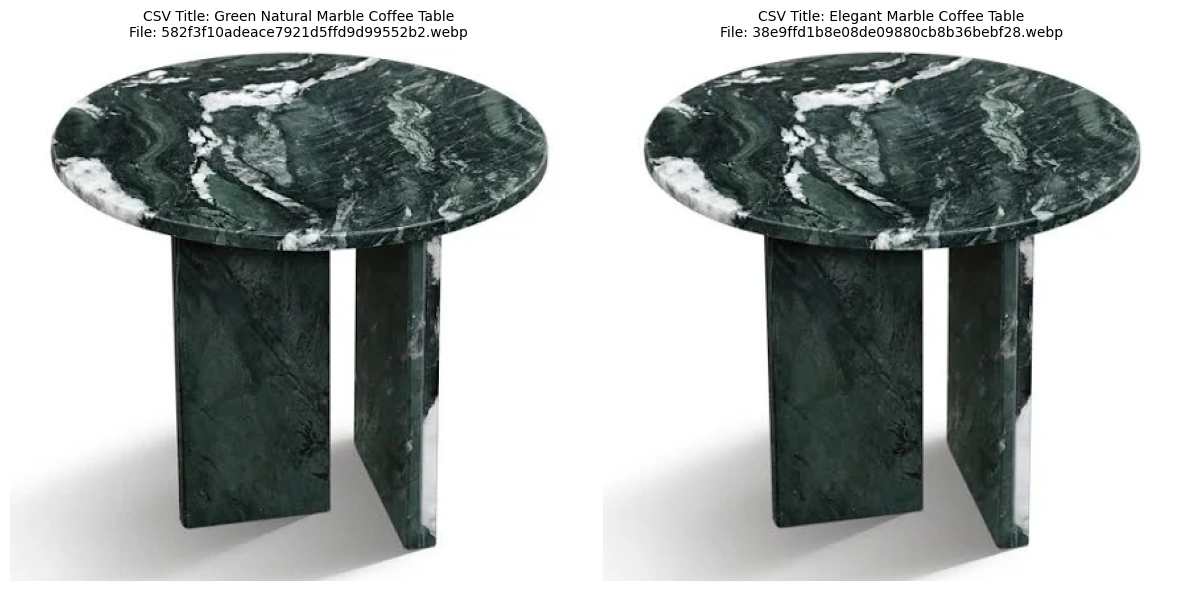

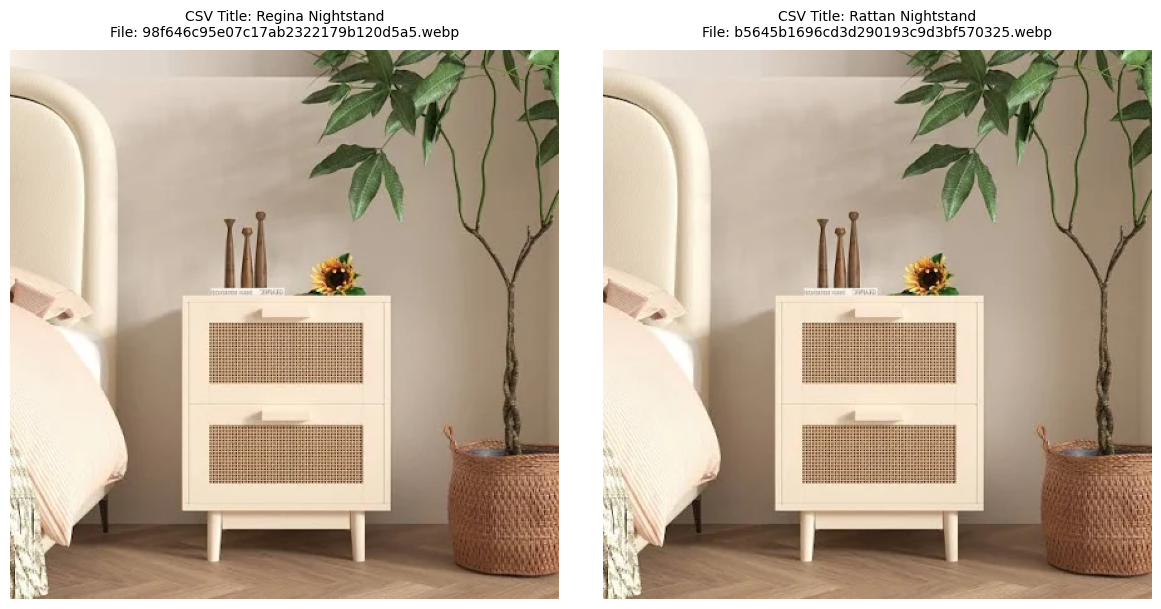

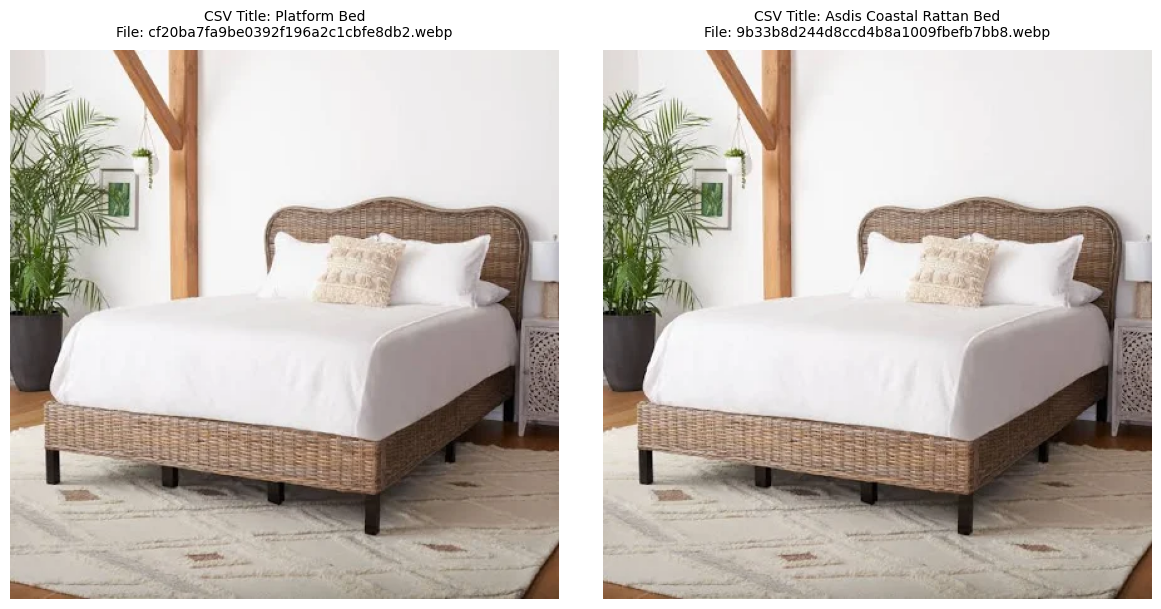

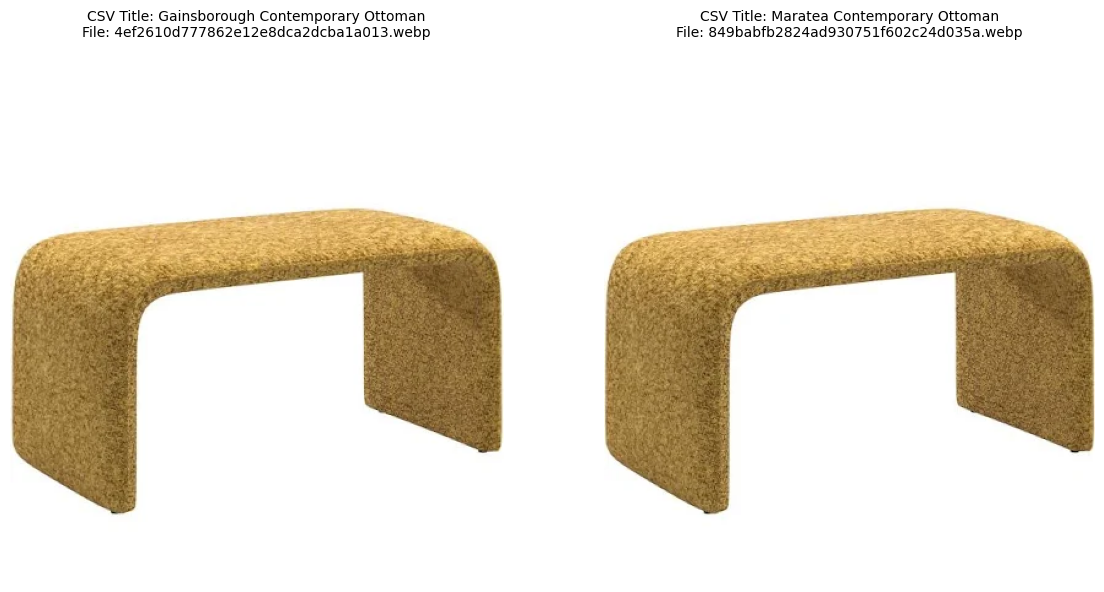

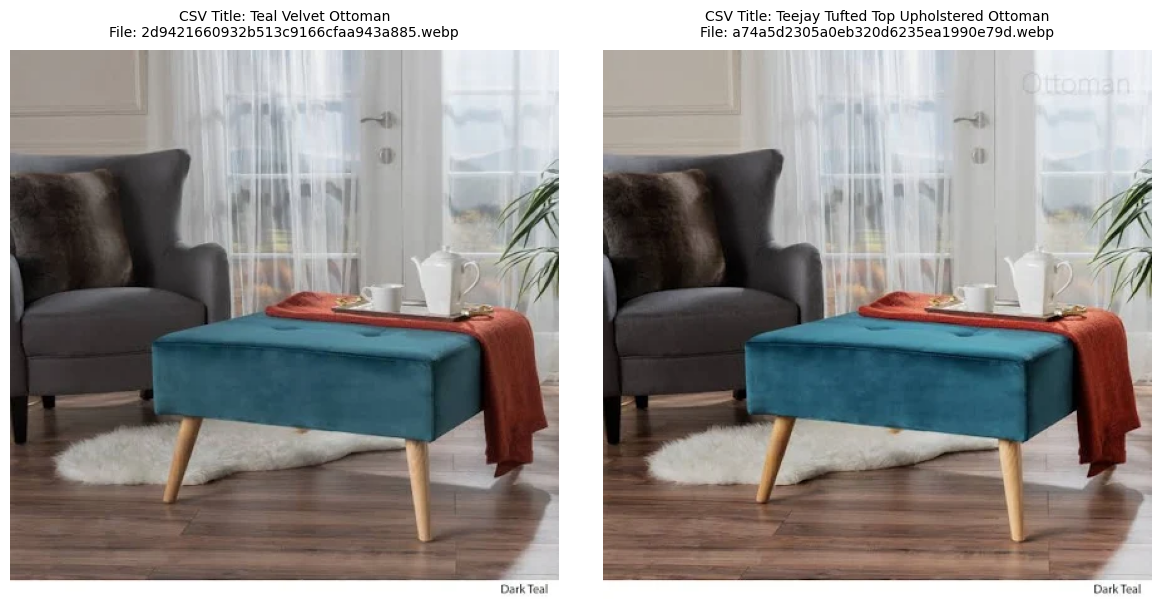

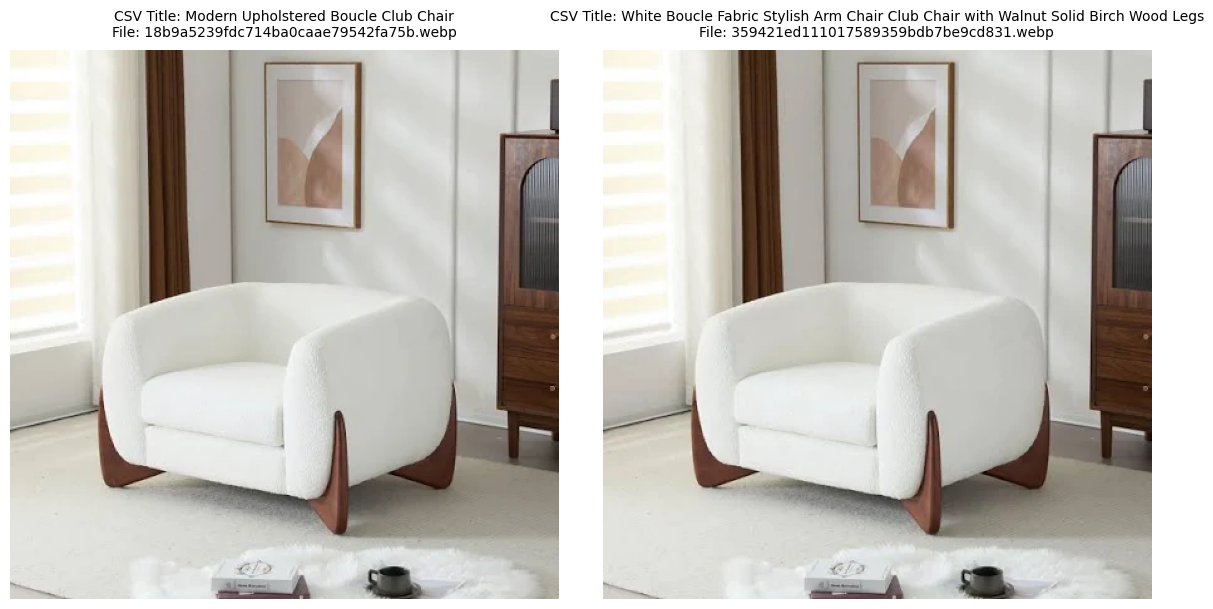

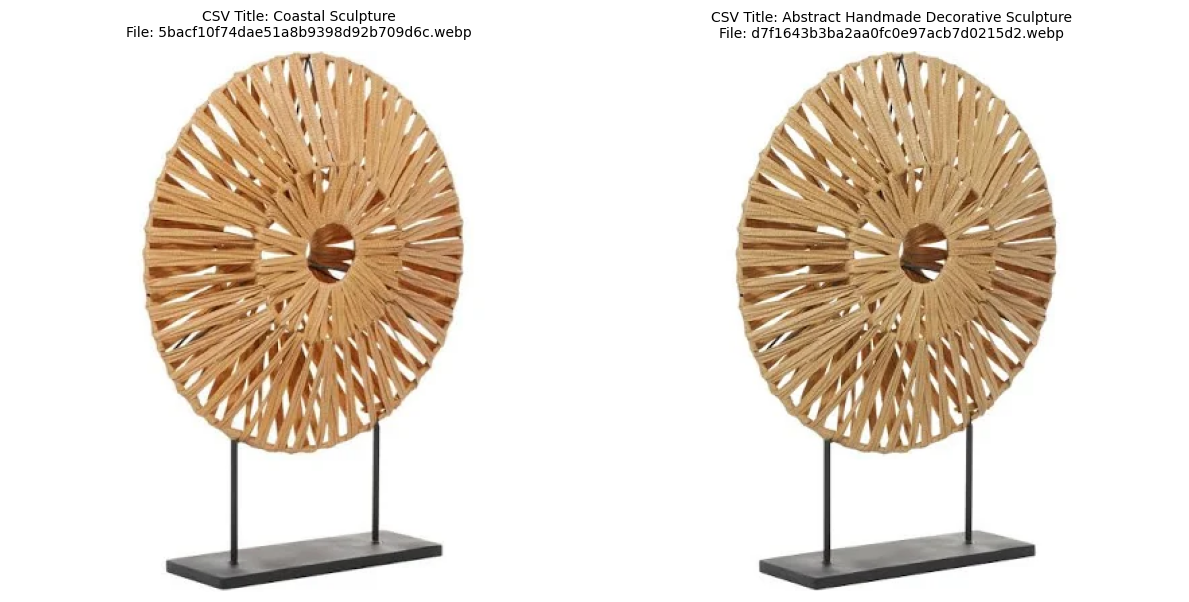

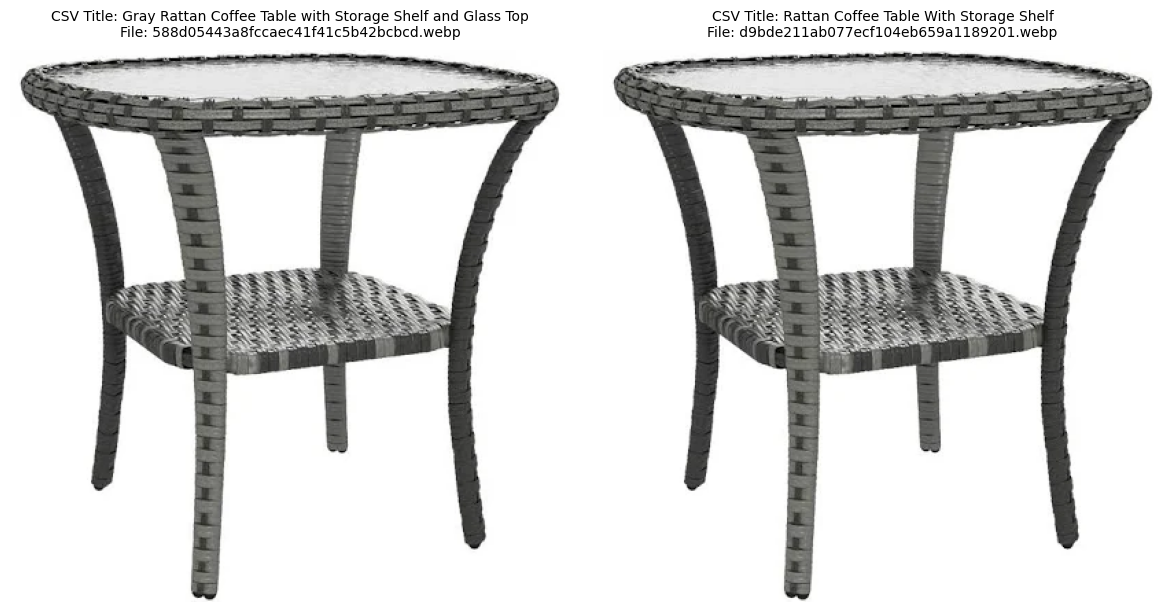

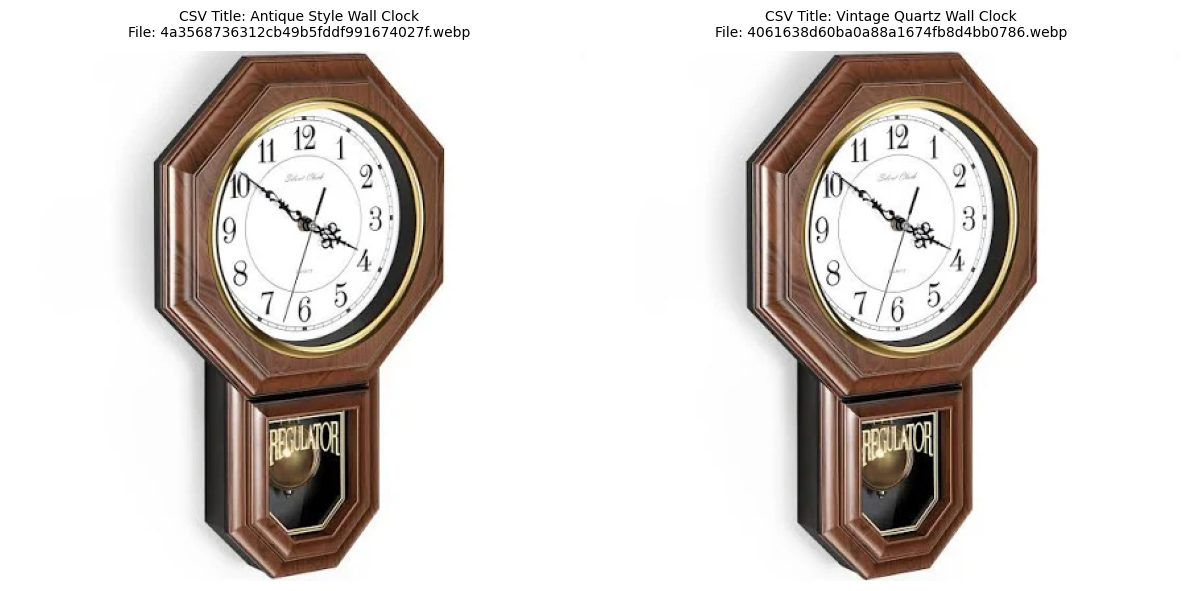

In [21]:
import os
import re
import matplotlib.pyplot as plt
from PIL import Image


# --- CONFIGURATION ---
# Path to the .txt report generated by Czkawka CLI or GUI
REPORT_PATH = R"C:\Users\nessi\duplicates_report_low.txt" 

# --- CONFIGURATION ---
CSV_PATH = R"C:\Users\nessi\CLIP_Fine_Tuning\CLIP_Fine_Tuning\furniture-search-engine\data\processed\cleaned_furniture.csv" # Your metadata file
IMAGES_ROOT = R"C:\Users\nessi\CLIP_Fine_Tuning\CLIP_Fine_Tuning\furniture-search-engine\data\raw"
NUM_PAIRS_TO_SHOW = 10

# 1. Load CSV and Pre-process Titles
print("Loading CSV and building title map...")
df = pd.read_csv(CSV_PATH)

# Logic: use cleaned_title, fallback to name, then 'object'
df['display_title'] = df['cleaned_title'].fillna(df['name']).fillna("object")

# Create a mapping dictionary: {filename: title}
# Using filename is safer because Czkawka uses absolute paths, 
# but your CSV uses local paths.
title_map = dict(zip(
    df['local_path'].astype(str).apply(os.path.basename), 
    df['display_title']
))

def parse_czkawka_report_with_titles(file_path, title_lookup):
    """
    Parses czkawka report and pairs each path with its CSV title.
    """
    if not os.path.exists(file_path):
        print(f"Error: Report file not found at {file_path}")
        return []

    groups = []
    current_group = []
    path_regex = re.compile(r'"([^"]+)"')

    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            if "Found" in line and "images" in line:
                if current_group:
                    groups.append(current_group)
                current_group = []
                continue
            
            match = path_regex.search(line)
            if match:
                full_path = match.group(1)
                filename = os.path.basename(full_path)
                
                # Retrieve title from our CSV map
                title = title_lookup.get(filename, "Title Not Found")
                
                if os.path.exists(full_path):
                    current_group.append({"path": full_path, "title": title})
        
        if current_group:
            groups.append(current_group)
            
    return groups

def visualize_groups(groups, limit=10):
    count = 0
    for group in groups:
        if len(group) < 2 or count >= limit:
            continue

        n_images = min(len(group), 3)
        fig, axes = plt.subplots(1, n_images, figsize=(6 * n_images, 6))
        
        if n_images == 1: axes = [axes]

        for i in range(n_images):
            item = group[i]
            try:
                img = Image.open(item['path'])
                axes[i].imshow(img)
                # Show the Title from the CSV
                axes[i].set_title(f"CSV Title: {item['title']}\nFile: {os.path.basename(item['path'])}", 
                                  fontsize=10, pad=10)
                axes[i].axis('off')
            except Exception as e:
                axes[i].text(0.5, 0.5, f"Error: {e}", ha='center')
                axes[i].axis('off')

        plt.tight_layout()
        plt.show()
        count += 1

# --- EXECUTION ---
groups_with_data = parse_czkawka_report_with_titles(REPORT_PATH, title_map)
print(f"Found {len(groups_with_data)} groups. Displaying top {NUM_PAIRS_TO_SHOW}:")
visualize_groups(groups_with_data, limit=NUM_PAIRS_TO_SHOW)